# Exploratory data analysis

In [4]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime as dt
import re

warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 500)

RANDOM_STATE = 1

### Load Data

In [8]:
def read_pickle(path):
    f = open(path, "rb")
    return pickle.load(f)

d = read_pickle('../data/downloaded/raw_swe_parl_mot.pkl')
raw = pd.DataFrame(d)

In [9]:
df = raw.copy()
df['date'] = pd.to_datetime(df['date'])

In [18]:
t = pd.read_csv("../data/test/test_data.csv")
t

,text,summary
0,"Avstängning av Södra länken i Stockholm sker ofta vid stillastående köer. Det är helt och hållet en säkerhetsfråga eftersom det saknas sprinklers i tunneln för att kunna hantera bränder. Man måste kunna säkerställa att det inte är för många fordon i tunneln samtidigt. Detta ställer naturligtvis till problem för många delar av stadens trafik när tunneln är full och infarter stängs av, vilket leder till kaos på många ställen. När Södra länken byggdes installerades aldrig sprinklers, vilket i s...","""Sprinklers i Södra länken i Stockholm"""


In [10]:
# Show sample rows
display(df.sample(5, random_state=RANDOM_STATE))

,id,date,file_date,title,subtitle,text,main_author,author_party
76854,G902Jo220,1986-01-21,2014-11-04 10:23:46,Ändringar i jordförvärv slagen,Margareta Gard (m),"Observera att dokumentet är inskannat och fel kan förekomma. Motion till riksdagen 1985/86: Jo220 Margareta Gard (m) Ändringar i jordförvärv slagen Den nuvarande jordförvärvslagen har ensidigt varit inriktad på stordrift och intensivbrukning av våra jordar. Genom en snabb mekanisering, utveckling av avel och växtförädling och en ökad användning av insatsvaror som handelsgödsel och bekämpningsmedel har produktivitetsökningen inom jordbruket varit utomordentligt stor. Detta har lett fram till ...",Margareta Gard,m
74966,G8023214,1985-05-08,2014-10-13 16:25:05,"Förslag till slutlig reglering av statsbudgeten för budgetåret 1985/86,",Stig Alemyr m. fl.,"Observera att dokumentet är inskannat och fel kan förekomma. 25 Motion 1984/85:3214 Stig Alemyr m. fl. Förslag till slutlig reglering av statsbudgeten för budgetåret 1985/86, m.m. (kompletteringsproposition) (prop. 1984/85:150) Länsarbetsnämnden i Kalmar län gör i sina bedömningar av byggarbetsmarknaden i länet för kommande tolvmånadersperiod (daterat den 2 april 1985) bl. a. följande konstaterande: Byggaktiviteten är låg och svag sysselsättning förutses för perioden i norra, mellersta och s...",STIG ALEMYR,s
146941,GE02Ju706,1991-01-25,2005-11-02 21:28:53,Underåriga brottsoffer,av Bengt Harding Olson (fp),Motion till riksdagen 1990/91:Ju706 av Bengt Harding Olson (fp) Underåriga brottsoffer I ett rättssamhälle är det mycket viktigt att kriminella övergrepp handlägges skyndsamt inom rättsväsendet. Särskilt angeläget är detta när brottmålet gäller underåriga personer. Gällande lag stadgar förtur för mål med underåriga lagöverträdare. Men regler saknas för sådana fall då den underårige är brottsoffer/målsägande. Även om det är stor skillnad i rättsligt hänseende mellan gärningsman och brottsoffe...,Bengt Harding Olson,fp
77537,G902L239,1986-01-24,2014-11-04 10:31:19,Ändrade bestämmelser om räkenskapsår i bokföringslagen,Lars Ernestam och Ingela Mårtensson (fp),"Observera att dokumentet är inskannat och fel kan förekomma. Motion till riksdagen 1985/86 :L239 Lars Ernestam och Ingela Mårtensson (fp) Ändrade bestämmelser om räkenskapsår i bokföringslagen Mot. 1985/86 L239-248 En ny bokföringslag trädde i kraft den 1 januari 1977. Denna innebar bl. a. en skärpning i förhållande till tidigare rätt beträffande räkenskapsperioderna och medger ej andra räkenskapsår än de som sammanfaller med kalenderår eller perioderna den 1 maj-den 30 april, den 1 juli-den...",Lars Ernestam,fp
127785,H102Ju379,2013-12-01,2013-12-20 13:56:00,Kriminalpolitisk partimotion,av Jimmie Åkesson m.fl. (SD),Motion till riksdagen 2013/14:Ju379 av Jimmie Åkesson m.fl. (SD) Kriminalpolitisk partimotion SD259 Förslag till riksdagsbeslut Riksdagen tillkännager för regeringen som sin mening vad som anförs i motionen om att införa ett system där staten betalar ut utdömda skadestånd till brottsoffret efter att domen vunnit laga kraft och där staten därefter kräver in beloppet från gärningsmannen. Riksdagen tillkännager för regeringen som sin mening vad som anförs i motionen om att utreda i vilken grad ...,Jimmie Åkesson,SD


### Preprocessing

The motion texts often starts with *'Motion till riksdagen \<motion identifyer\>'* and then state the author and the associated party *'av \<name\> (\<party initial\>)'* followed by the title. For example, the text of the motion with title *Norrbotniabanan* starts with:  
Motion till riksdagen 2010/11:T230 av Maria Lundqvist-Brömster (FP) Norrbotniabanan  

Let's filter the first sentences which are not really part of the motion text by:  
* splitting the motion text at the first occurance of 'av \<name\> (\<party initial\>)'  
* then, if the new string starts with the title, drop that part too

We'll also drop the author's name which is often present at the end of the text

In [5]:
# Make all text lower case
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.lower()

In [6]:
def trim_motion_text_by_subtitle(row):
    split = row['text'].split(row['subtitle'], 1)
    return split[-1].strip()

df['text'] = df.apply(trim_motion_text_by_subtitle, axis=1)
display(df.sample(5, random_state=RANDOM_STATE))

,id,date,title,subtitle,text,main_author,author_party
96317,gf02ub418,1992-01-27,den bebyggelseantikvariska linjen,av iréne vestlund och karl-erik svartberg (s),"resursförstärkning och värdering av bebyggelseantikvarisk linje riksdagen fattade 1985/86 beslut (ubu 1985/86:25) ominrättande av en allmän linje, bebyggelseantikvariska linjen om 120 poäng den 1 juli 1986 samtatt inrätta linjen i göteborg med 20 utbildningsplatser. utbildningen, som är den enda i sitt slag i landet och som framvuxit ur lokala initiativ vid göteborgs universitet, har visat sig både ha stor livskraft och motsvara allmänna och långsiktiga utbildningsbehov på nationell nivå. va...",iréne vestlund,s
165108,g20280,1978-11-23,med anledning av propositionen 1978/79:25 med förslag om tilläggsbudget i till statsbudgeten för budgetåret 1978/79,av per-olof strindberg m. fl.,"med anledning av propositionen 1978/79:25 med förslag om tilläggsbudget i till statsbudgeten för budgetåret 1978/79 i propositionen 1977/78:30 om skyddat arbete och yrkesinriktad rehabilitering m. m. föreslogs att landstingskommunerna tillsammans med staten inom varje landstingsområde skall bilda regionala stiftelser för skyddat arbete. detta blev också riksdagens beslut. i samma proposition föreslogs också att de regionala stiftelserna skulle ledas av en styrelse, där landstingen skulle väl...",per-olof strindberg,m
147775,fu02632,1971-01-27,angående försäljningen av mellanöl.,av herr stålhammar m. fl.,angående försäljningen av mellanöl. antagandet att mellanölet skulle leda till en minskning av starkspritkonsumtionen visade sig vara ett stort misstag. konsumtionen av starksprit har hållit sig i det närmaste konstant sedan 1955. därtill kommer att förbrukningen av vin ökat med 60 % mellan 1955 och 1968. med mellanölets införande drevs ölkonsumtionen i höjden och medförde samtidigt övergång från den svagare pilsnern till mellanölet under det att starkölsförbrukningen fortsatte att öka. situ...,bert stålhammar,fp
76582,gm02so23,1999-04-28,med anledning av prop. 1998/99:106 vissa ändringar i läkemedelsförmånen m.m.,av kerstin heinemann m.fl. (fp),med anledning av prop. 1998/99:106 vissa ändringar i läkemedelsförmånen m.m. regeringen agerar i paniksamhällets utgifter för läkemedel fortsätter att öka i snabb takt. antalet patienter som uppnått beloppet för högkostnadsskydd inom läkemedelsförmånen överstiger den tidigare prognosen och uppgår nu närmare till 800 000 personer. som regeringen konstaterar har kostnaderna för läkemedlen stigit med drygt 6 miljarder kronor mellan åren 1990 och 1998. det är viktigt att det vidtas åtgärder för ...,kerstin heinemann,fp
38076,h002n7,2012-11-06,med anledning av prop. 2012/13:21 forskning och innovation för ett långsiktigt hållbart energisystem,av lars isovaara (sd),med anledning av prop. 2012/13:21 forskning och innovation för ett långsiktigt hållbart energisystem sd178 förslag till riksdagsbeslut riksdagen tillkännager för regeringen som sin mening vad som anförs i motionen om att forskning inom kärnkraft ska ingå som ett prioriterat område. motivering sverige är ett exportberoende land. den tunga basindustrin står för ett stort nettoexportvärde och är också av stor betydelse som arbetsgivare på många orter och inom stora delar av vårt land. basindust...,lars isovaara,sd


In [7]:
def trim_motion_text_by_title(row):
    if row['text'].startswith(row['title']):
        text = row['text'].split(row['title'], 1)[-1].strip()
    else:
        text = row['text']
    return text

df['text'] = df.apply(trim_motion_text_by_title, axis=1)
display(df.sample(5, random_state=RANDOM_STATE))

,id,date,title,subtitle,text,main_author,author_party
96317,gf02ub418,1992-01-27,den bebyggelseantikvariska linjen,av iréne vestlund och karl-erik svartberg (s),"resursförstärkning och värdering av bebyggelseantikvarisk linje riksdagen fattade 1985/86 beslut (ubu 1985/86:25) ominrättande av en allmän linje, bebyggelseantikvariska linjen om 120 poäng den 1 juli 1986 samtatt inrätta linjen i göteborg med 20 utbildningsplatser. utbildningen, som är den enda i sitt slag i landet och som framvuxit ur lokala initiativ vid göteborgs universitet, har visat sig både ha stor livskraft och motsvara allmänna och långsiktiga utbildningsbehov på nationell nivå. va...",iréne vestlund,s
165108,g20280,1978-11-23,med anledning av propositionen 1978/79:25 med förslag om tilläggsbudget i till statsbudgeten för budgetåret 1978/79,av per-olof strindberg m. fl.,"i propositionen 1977/78:30 om skyddat arbete och yrkesinriktad rehabilitering m. m. föreslogs att landstingskommunerna tillsammans med staten inom varje landstingsområde skall bilda regionala stiftelser för skyddat arbete. detta blev också riksdagens beslut. i samma proposition föreslogs också att de regionala stiftelserna skulle ledas av en styrelse, där landstingen skulle välja hela styrelsen utom vice ordföranden. föredragande statsrådet anförde bl. a.: jag förordar att varje styrelse bes...",per-olof strindberg,m
147775,fu02632,1971-01-27,angående försäljningen av mellanöl.,av herr stålhammar m. fl.,antagandet att mellanölet skulle leda till en minskning av starkspritkonsumtionen visade sig vara ett stort misstag. konsumtionen av starksprit har hållit sig i det närmaste konstant sedan 1955. därtill kommer att förbrukningen av vin ökat med 60 % mellan 1955 och 1968. med mellanölets införande drevs ölkonsumtionen i höjden och medförde samtidigt övergång från den svagare pilsnern till mellanölet under det att starkölsförbrukningen fortsatte att öka. situationen är den att vi för närvarande...,bert stålhammar,fp
76582,gm02so23,1999-04-28,med anledning av prop. 1998/99:106 vissa ändringar i läkemedelsförmånen m.m.,av kerstin heinemann m.fl. (fp),regeringen agerar i paniksamhällets utgifter för läkemedel fortsätter att öka i snabb takt. antalet patienter som uppnått beloppet för högkostnadsskydd inom läkemedelsförmånen överstiger den tidigare prognosen och uppgår nu närmare till 800 000 personer. som regeringen konstaterar har kostnaderna för läkemedlen stigit med drygt 6 miljarder kronor mellan åren 1990 och 1998. det är viktigt att det vidtas åtgärder för att minska kostnaderna för att människor i framtiden skall kunna erhålla läke...,kerstin heinemann,fp
38076,h002n7,2012-11-06,med anledning av prop. 2012/13:21 forskning och innovation för ett långsiktigt hållbart energisystem,av lars isovaara (sd),sd178 förslag till riksdagsbeslut riksdagen tillkännager för regeringen som sin mening vad som anförs i motionen om att forskning inom kärnkraft ska ingå som ett prioriterat område. motivering sverige är ett exportberoende land. den tunga basindustrin står för ett stort nettoexportvärde och är också av stor betydelse som arbetsgivare på många orter och inom stora delar av vårt land. basindustrin står för en betydande del av elkraftskonsumtionen. vi ser att inom en överskådlig framtid kommer ...,lars isovaara,sd


That's better, but now some of the texts starts with a recommendation for a parliament decision. We wan't to delete that part as well


In [8]:
def trim_motion_text_by_proposed_decision(row):
    split = re.split("förslag till riksdagsbeslut riksdagen [A-ö0-9\s,]+\.\s|" +\
                     "riksdagen tillkännager för regeringen som sin mening [A-ö0-9\s,]+\.\s|" +\
                     "riksdagen ställer sig bakom det som anförs [A-ö0-9\s,]+\.\s",
                     row['text'])
    return split[-1].strip()

df['text'] = df.apply(trim_motion_text_by_proposed_decision, axis=1)
display(df.sample(5, random_state=RANDOM_STATE))

,id,date,title,subtitle,text,main_author,author_party
96317,gf02ub418,1992-01-27,den bebyggelseantikvariska linjen,av iréne vestlund och karl-erik svartberg (s),"resursförstärkning och värdering av bebyggelseantikvarisk linje riksdagen fattade 1985/86 beslut (ubu 1985/86:25) ominrättande av en allmän linje, bebyggelseantikvariska linjen om 120 poäng den 1 juli 1986 samtatt inrätta linjen i göteborg med 20 utbildningsplatser. utbildningen, som är den enda i sitt slag i landet och som framvuxit ur lokala initiativ vid göteborgs universitet, har visat sig både ha stor livskraft och motsvara allmänna och långsiktiga utbildningsbehov på nationell nivå. va...",iréne vestlund,s
165108,g20280,1978-11-23,med anledning av propositionen 1978/79:25 med förslag om tilläggsbudget i till statsbudgeten för budgetåret 1978/79,av per-olof strindberg m. fl.,"i propositionen 1977/78:30 om skyddat arbete och yrkesinriktad rehabilitering m. m. föreslogs att landstingskommunerna tillsammans med staten inom varje landstingsområde skall bilda regionala stiftelser för skyddat arbete. detta blev också riksdagens beslut. i samma proposition föreslogs också att de regionala stiftelserna skulle ledas av en styrelse, där landstingen skulle välja hela styrelsen utom vice ordföranden. föredragande statsrådet anförde bl. a.: jag förordar att varje styrelse bes...",per-olof strindberg,m
147775,fu02632,1971-01-27,angående försäljningen av mellanöl.,av herr stålhammar m. fl.,antagandet att mellanölet skulle leda till en minskning av starkspritkonsumtionen visade sig vara ett stort misstag. konsumtionen av starksprit har hållit sig i det närmaste konstant sedan 1955. därtill kommer att förbrukningen av vin ökat med 60 % mellan 1955 och 1968. med mellanölets införande drevs ölkonsumtionen i höjden och medförde samtidigt övergång från den svagare pilsnern till mellanölet under det att starkölsförbrukningen fortsatte att öka. situationen är den att vi för närvarande...,bert stålhammar,fp
76582,gm02so23,1999-04-28,med anledning av prop. 1998/99:106 vissa ändringar i läkemedelsförmånen m.m.,av kerstin heinemann m.fl. (fp),regeringen agerar i paniksamhällets utgifter för läkemedel fortsätter att öka i snabb takt. antalet patienter som uppnått beloppet för högkostnadsskydd inom läkemedelsförmånen överstiger den tidigare prognosen och uppgår nu närmare till 800 000 personer. som regeringen konstaterar har kostnaderna för läkemedlen stigit med drygt 6 miljarder kronor mellan åren 1990 och 1998. det är viktigt att det vidtas åtgärder för att minska kostnaderna för att människor i framtiden skall kunna erhålla läke...,kerstin heinemann,fp
38076,h002n7,2012-11-06,med anledning av prop. 2012/13:21 forskning och innovation för ett långsiktigt hållbart energisystem,av lars isovaara (sd),motivering sverige är ett exportberoende land. den tunga basindustrin står för ett stort nettoexportvärde och är också av stor betydelse som arbetsgivare på många orter och inom stora delar av vårt land. basindustrin står för en betydande del av elkraftskonsumtionen. vi ser att inom en överskådlig framtid kommer de befintliga kärnkraftsreaktorerna att behöva bytas ut för att säkerställa en långsiktig tryggad energiförsörjning. ett framtida läge med en nedläggning och utflyttning av svensk ba...,lars isovaara,sd


In [9]:
def trim_motion_text_by_author(row):
    end_string = f"{row['main_author']} ({row['author_party']})"
    if row['text'].endswith(end_string):
        text = row['text'].removesuffix(end_string).strip()
    else:
        text = row['text']
    return text

df['text'] = df.apply(trim_motion_text_by_author, axis=1)
display(df.sample(5, random_state=RANDOM_STATE))

,id,date,title,subtitle,text,main_author,author_party
96317,gf02ub418,1992-01-27,den bebyggelseantikvariska linjen,av iréne vestlund och karl-erik svartberg (s),"resursförstärkning och värdering av bebyggelseantikvarisk linje riksdagen fattade 1985/86 beslut (ubu 1985/86:25) ominrättande av en allmän linje, bebyggelseantikvariska linjen om 120 poäng den 1 juli 1986 samtatt inrätta linjen i göteborg med 20 utbildningsplatser. utbildningen, som är den enda i sitt slag i landet och som framvuxit ur lokala initiativ vid göteborgs universitet, har visat sig både ha stor livskraft och motsvara allmänna och långsiktiga utbildningsbehov på nationell nivå. va...",iréne vestlund,s
165108,g20280,1978-11-23,med anledning av propositionen 1978/79:25 med förslag om tilläggsbudget i till statsbudgeten för budgetåret 1978/79,av per-olof strindberg m. fl.,"i propositionen 1977/78:30 om skyddat arbete och yrkesinriktad rehabilitering m. m. föreslogs att landstingskommunerna tillsammans med staten inom varje landstingsområde skall bilda regionala stiftelser för skyddat arbete. detta blev också riksdagens beslut. i samma proposition föreslogs också att de regionala stiftelserna skulle ledas av en styrelse, där landstingen skulle välja hela styrelsen utom vice ordföranden. föredragande statsrådet anförde bl. a.: jag förordar att varje styrelse bes...",per-olof strindberg,m
147775,fu02632,1971-01-27,angående försäljningen av mellanöl.,av herr stålhammar m. fl.,antagandet att mellanölet skulle leda till en minskning av starkspritkonsumtionen visade sig vara ett stort misstag. konsumtionen av starksprit har hållit sig i det närmaste konstant sedan 1955. därtill kommer att förbrukningen av vin ökat med 60 % mellan 1955 och 1968. med mellanölets införande drevs ölkonsumtionen i höjden och medförde samtidigt övergång från den svagare pilsnern till mellanölet under det att starkölsförbrukningen fortsatte att öka. situationen är den att vi för närvarande...,bert stålhammar,fp
76582,gm02so23,1999-04-28,med anledning av prop. 1998/99:106 vissa ändringar i läkemedelsförmånen m.m.,av kerstin heinemann m.fl. (fp),regeringen agerar i paniksamhällets utgifter för läkemedel fortsätter att öka i snabb takt. antalet patienter som uppnått beloppet för högkostnadsskydd inom läkemedelsförmånen överstiger den tidigare prognosen och uppgår nu närmare till 800 000 personer. som regeringen konstaterar har kostnaderna för läkemedlen stigit med drygt 6 miljarder kronor mellan åren 1990 och 1998. det är viktigt att det vidtas åtgärder för att minska kostnaderna för att människor i framtiden skall kunna erhålla läke...,kerstin heinemann,fp
38076,h002n7,2012-11-06,med anledning av prop. 2012/13:21 forskning och innovation för ett långsiktigt hållbart energisystem,av lars isovaara (sd),motivering sverige är ett exportberoende land. den tunga basindustrin står för ett stort nettoexportvärde och är också av stor betydelse som arbetsgivare på många orter och inom stora delar av vårt land. basindustrin står för en betydande del av elkraftskonsumtionen. vi ser att inom en överskådlig framtid kommer de befintliga kärnkraftsreaktorerna att behöva bytas ut för att säkerställa en långsiktig tryggad energiförsörjning. ett framtida läge med en nedläggning och utflyttning av svensk ba...,lars isovaara,sd


Finally, consider all (title, text) pairs and drop duplicates from the data set.

In [10]:
print("Number of motions that are duplicates when only considering the 'title' and 'text' columns:", 
      df.duplicated(subset=['title', 'text']).sum())

# Drop those rows
df = df.drop_duplicates(subset=['title', 'text'], keep='first').copy()

Number of motions that are duplicates when only considering the 'title' and 'text' columns: 1002


### Describe Data

In [11]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166391 entries, 0 to 167392
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            166391 non-null  object        
 1   date          166391 non-null  datetime64[ns]
 2   title         166391 non-null  object        
 3   subtitle      165865 non-null  object        
 4   text          166391 non-null  object        
 5   main_author   166390 non-null  object        
 6   author_party  166298 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 10.2+ MB


None

About 167k samples. Let's just go ahead and drop any row with a missing value, for simplicity.

In [12]:
df = df.dropna()
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165773 entries, 0 to 167392
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            165773 non-null  object        
 1   date          165773 non-null  datetime64[ns]
 2   title         165773 non-null  object        
 3   subtitle      165773 non-null  object        
 4   text          165773 non-null  object        
 5   main_author   165773 non-null  object        
 6   author_party  165773 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 10.1+ MB


None

In [13]:
display(df.describe())

,id,date,title,subtitle,text,main_author,author_party
count,165773,165773,165773,165773,165773,165773,165773
unique,165773,4382,107975,29590,165399,4065,43
top,h6021,1991-01-25 00:00:00,med anledning av prop. 1989/90:90 om forskning,av sten bergheden (m),dokument saknas,lars werner,m
freq,1,3719,200,832,86,2677,41199
first,NaN,1970-01-12 00:00:00,NaN,NaN,NaN,NaN,NaN
last,NaN,2022-01-20 00:00:00,NaN,NaN,NaN,NaN,NaN


There's a few things to note here.
* The ID's are unique. 
* On the yop date 25th Jan 1991 there were 3 719 motions filed. That warrants a closer look.  
* The titles are not unique. In fact 200 motions share the same title "med anledning av prop. 1989/90:90 om forskning"  
* There's som cleaning up left to do based on the text-column. Now 125 only has 'dokument sakans' (document missing) as string.  We'll want to drop those from the data.

#### Missing Documents

In [14]:
# Drop missing docs
df = df.loc[df['text'].isin(['dokument saknas', '', 'motionen utgår.', 'motionen återtagen', '.']) == False].copy()
display(df[(df['text'].str.len() < 200)])

,id,date,title,subtitle,text,main_author,author_party
404,h6021362,2018-11-28,utbyggnad av riksväg 55,av jessika roswall och marta obminska (båda m),jessika roswall (m) marta obminska (m),jessika roswall,m
470,h6021421,2018-11-28,utveckla polisens karriärmöjligheter,av alexandra anstrell och maria stockhaus (båda m),alexandra anstrell (m) maria stockhaus (m),alexandra anstrell,m
1131,h6022017,2018-11-29,sälj sveaskog,av erik bengtzboe och ida drougge (båda m),erik bengtzboe (m) ida drougge (m),erik bengtzboe,m
3525,h7021362,2019-10-02,förbudet mot handel med sälprodukter,av alexandra anstrell m.fl. (m),alexandra anstrell (m) erik ottoson (m) mattias karlsson i luleå (m),alexandra anstrell,m
5678,h7023309,2019-10-03,kortare arbetstid,av rebecka le moine m.fl. (mp),rebecka le moine (mp) leila ali-elmi (mp) anna sibinska (mp),rebecka le moine,mp
...,...,...,...,...,...,...,...
145102,gd02so297,1989-01-01,alkoholmissbruket,av erik holmkvist m.fl. (m),motionen utgår. 13,av erik holmkvist m.fl.,m
145236,gd02so483,1989-01-01,patientjournallagen 1989/90,av hans nyhage (m),1 i lsj mot. patientjournallagen 1989/90 so483-490 motionen utgår. 1 riksdagen 1989/90. 3 sami. nr so483-490 1,av hans nyhage,m
145881,gd02u540,1989-01-01,motionen utgår.,av birger hagård m.fl. (m),angola motionen utgår. 1 riksdagen 1989190. 3 sami nr u540-546 rättelse: s. 1-4 flyttad till u658,av birger hagård m.fl.,m
160611,g002970,1977-01-21,om förenklade tullklareringsbestämmelser för allmänflyget,av herr clarkson,med hänvisning till vad som anförts i motionen 1976/77:969 hemställer jag att riksdagen hos regeringen begär förenklade tullklareringsbestämmelser för allmänflyget. stockholm den 21 januari 1977,rolf clarkson,m


There's still lots of junk where the text is very short. Let's make a cut at minimum 200 characters and take another look.

In [15]:
df = df[df['text'].str.len() > 200]
display(df[(df['text'].str.len() < 250)].sample(10))

,id,date,title,subtitle,text,main_author,author_party
76948,gm02t501,1998-10-28,citytunneln,av bertil persson (m),citytunneln brådskar! hemställan hemställanmed hänvisning till det anförda hemställs1. att riksdagen som sin mening ger regeringen till känna vad i motionen anförts om att citytunneln i malmö brådskar. stockholm den 7 oktober 1998 bertil persson (m),bertil persson,m
88815,ge02bo206,1991-01-25,boverkets instruktion,av ingvar björk och bo nilsson (s),hemställan med hänvisning till det anförda hemställs att riksdagen som sin mening ger regeringen till känna vad i motionen anförts om tillägg till boverkets instruktion. stockholm den 22 januari 1991 ingvar björk (s) bo nilsson (s),ingvar björk,s
92525,ge02t643,1991-01-25,betalning för isbrytarhjälp,av börje hörnlund (c),undertecknad föreslår att förslaget om betalning för isbrytarhjälp avslås. hemställan med hänvisning till det anförda hemställs att riksdagen avslår förslaget om betalning för isbrytarhjälp. stockholm den 25 januari 1991,börje hörnlund,c
166513,g3022075,1980-05-21,"med anledning av proposition 1979/80:175 om ändring i lagen (1977:975) med tulltaxa, m. m.",av daniel tarschys och karin ahrland,en höjning av priserna på tomat och gurka gagnar inte landets konsumenter. vi föreslår därför att riksdagen avslår de i proposition 1979/80:175 föreslagna tullhöjningarna. stockholm den 21 maj 1980 daniel tarschys (fp) karin ahrland (fp),daniel tarschys,fp
90909,ge02n353,1991-01-25,riskkapitalförsörjning i värmland,av kjell ericsson (c),hemställan med hänvisning till vad som anförts i motion 1990/91:a490 hemställs att riksdagen som sin mening ger regeringen till känna vad i motionen anförts om åtgärder för att öka tillgången på riskkapital. stockholm den 25 januari 1991,kjell ericsson,c
134357,gb02jo288,1988-01-26,om utveckling av kronobergs läns landsbygd,av stina gustavsson (c),hemställan med hänvisning till vad som anförts i motion 1987/88:a489 hemställs att riksdagen som sin mening ger regeringen till känna vad i motionen anförts om rationaliseringskungörelsen. stockholm den 26 januari 1988 stina gustavsson (c),av stina gustavsson,c
97753,gg02k204,1993-01-26,riksdagsledamöternas antal,av daniel tarschys (fp),hemställan med hänvisning till motionerna 1988/89:k324 och 1991/92:k202 föreslås att riksdagen beslutar om sådan ändring i regeringsformen att antalet riksdagsledamöter från 1997 års val minskas till 299. stockholm den 18 januari 1993,daniel tarschys,fp
131401,ga02l715,1987-01-26,reklam för och marknadsföring av snabbvinsatser,alf svensson (c),hemställan med hänvisning till vad som anförts i motion 1986/87:sk828 hemställs att riksdagen hos regeringen begär förslag till förbud mot reklam och marknadsföring av snabbvinsatser. stockholm den 26 januari 1987,alf svensson,c
143862,gd02l814,1990-01-25,patent på bioteknologiska uppfinningar,av roy ottosson m.fl. (mp),hemställan med hänvisning till vad som anförts i motion 1989/90:jo622 hemställs att riksdagen uttryckligen förbjuder patent på levande organismer. stockholm den 25 januari 1990 roy ottosson (mp) åsa domeij (mp) marianne samuelsson (mp),av roy ottosson m.fl.,mp
118599,g6021668,1983-01-25,finansieringen av narkotikahandeln,tore nilsson,med hänvisning till vad som anförts i motion 1982/83:1666 hemställs att riksdagen hos regeringen anhåller om skärpta åtgärder mot finansieringen av narkotikahandeln. stockholm den 25 januari 1983 tore nilsson (m) minab/gotab stockholm 1983 73550,tore nilsson,m


Better!

#### The many documents with title 'med anledning av prop. 1989/90:90 om forskning'

In [16]:
df.loc[df['title'] == 'med anledning av prop. 1989/90:90 om forskning'].head(10)

,id,date,title,subtitle,text,main_author,author_party
141750,gd02a24,1990-03-19,med anledning av prop. 1989/90:90 om forskning,av anders högmark m.fl. (m),"1. inledning inom arbetsmarknadsdepartementets ansvarsområde ligger bl.a. arbetsmiljöforskning och forskning kring s.k. arbetslivsfrågor. inom dessa områden finns det omfattande forskningsmöjligheter. villkoren och förutsättningarna för forskning inom dessa områden är dock speciella. en mycket stor del av forskningsanslagen kanaliseras genom särskilda organ såsom delegationen för arbetsmarknadspolitisk forskning (efa), arbetsmiljöfonden, arbetsmiljöinstitutet och arbetslivscentrum. det betyd...",av anders högmark m.fl.,m
141761,gd02a25,1990-03-20,med anledning av prop. 1989/90:90 om forskning,av sven-åke nygårds m.fl. (s),förhållandena inom arbetsmiljöområdet har rönt en stegrande uppmärksamhet under senare år. detta visas av att en arbetsmiljökommission har tillsatts. inrättandet av en arbetslivsfond talar samma språk. i den forskningspolitiska propositionen 1989/90:90 har inte detta slagit igenom på samma sätt. för oss är det uppenbart att miljöhänsyn även måste omfatta arbetsmiljö. ett uttalande från riksdagen bör göras med innebörden att sambandet mellan arbetsmiljöforskning och övrig miljöforskning bör f...,av sven-åke nygårds m.fl.,s
141772,gd02a26,1990-03-20,med anledning av prop. 1989/90:90 om forskning,av jan hyttring och kjell ericsson (båda c),hemställan med hänvisning till vad som anförts i motion 1989/90:ubl45 hemställs att riksdagen beslutar att som sin mening ge regeringen till känna vad i motionen föreslås för arbetslivsforskning vid högskolan i karlstad. stockholm den 20 mars 1990 jan hyttring (c) kjell ericsson (c),jan hyttring,c
141783,gd02a27,1990-03-20,med anledning av prop. 1989/90:90 om forskning,av krister skånberg (mp),"i denna motion anger jag en rad behov av lokal och regional utveckling och forskning och begär regeringsförslag om och resurser för sådan forskning. 1. det behövs forskning om ev förändrade förutsättningar för en aktiv regionalpolitik i samband med den europeiska integrationen. vilka spelregler kan och får vi använda i sverige om eg:s regler skall gälla även här? kan vi fortsätta med paketlösningar? 2. det behövs forskning om kommunernas nya roll i arbetsmarknads-, industri- och regionalpoli...",av krister skånberg,mp
141794,gd02a28,1990-03-20,med anledning av prop. 1989/90:90 om forskning,av carl bildt m.fl. (m),hemställan med hänvisning till vad som anförts i motion 1989/90:ubl25 hemställs att riksdagen som sin mening ger regeringen till känna vad i motionen anförts om en avveckling av verksamheten i dess nuvarande form vid arbetslivscentrum och arbetsmiljöinstitutet. stockholm den 20 mars 1990 carl bildt (m) lars tobisson (m) anders björck (m) rolf clarkson (m) ann-cathrine haglund (m) gullan lindblad (m) ingegerd troedsson (m) görel bohlin (m) rolf dahlberg (m) gunnar hökmark (m) bo lundgren (m) ...,av carl bildt m.fl.,m
141805,gd02a29,1990-03-20,med anledning av prop. 1989/90:90 om forskning,av lars werner m.fl. (vpk),"hemställan med hänvisning till vad som anförts i motion 1989/90:ubl39 hemställs att riksdagen till arbetsmiljöinstitutet anslår 1 000000 kr. utöver regeringens förslag, för informationsverksamhet i enlighet med vad som anförts i motionen. stockholm den 20 mars 1990 lars werner (vpk) bertil måbrink (vpk) bo hammar (vpk) lars-ove hagberg (vpk) björn samuelson (vpk) berith eriksson (vpk) margo ingvardsson (vpk) ylva johansson (vpk)",av lars werner m.fl.,vpk
141815,gd02a30,1990-03-20,med anledning av prop. 1989/90:90 om forskning,börje hörnlund m.fl. (c),"hemställan med hänvisning till vad som anförts i motion 1989/90:n45 hemställs 1. att riksdagen som sin mening ger regeringen till känna vad som i motionen anförts om behovet av en förstärkt forskning kring landsbygdens förhållanden och utveckling, 2. att riksdagen beslutar att till landsbygdens forskningsråd anvisa ett reservationsanslag under åttonde huvudtiteln på 

At least after eye-balling just a few of these motions they seem fine. They're different documents, just on the same topic. But since we cant look at them all, let's drop any rows with identical combination of title and text.

#### Over 3k motions on 1991-01-25

Let's first see how may motions are usually filed on any particular date

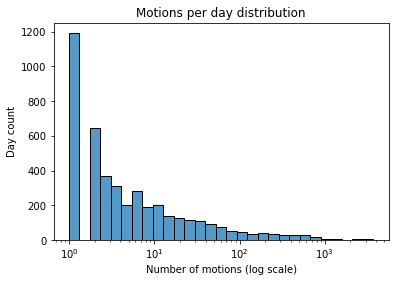

In [17]:
sns.histplot(df.groupby('date').size(), kde=False, log_scale=True)
plt.title('Motions per day distribution')
plt.xlabel('Number of motions (log scale)')
plt.ylabel('Day count')
plt.show()

While 3k+ on a day is certainly an outlier, it's not the only date that has a large number of motions associated with it. Below is the top ten most common titles for motions on 25th Jan 1991.

In [18]:
# Show top ten titles on 1991-01-25
display(df[df['date'].dt.date == dt(1991, 1, 25).date()].title.value_counts().head(10))

med anledning av prop. 1990/91:69 arbetslivsforskningens organisation m.m.    8
rattfylleri                                                                   8
avskaffande av skogsvårdsavgiften                                             7
riksteatern                                                                   6
det allmännas skadeståndsansvar                                               6
den ekonomiska politiken                                                      5
transportstödet                                                               5
registrerat partnerskap för homosexuella                                      5
vägverkets organisation                                                       5
med anledning av prop. 1990/91:71 lag om vissa dryckesförpackningar           5
Name: title, dtype: int64

There's not a high number of motions on any one title. I'm going to assume that these motions are valid data (maybe just filed on the wrong date).

### Motions per year

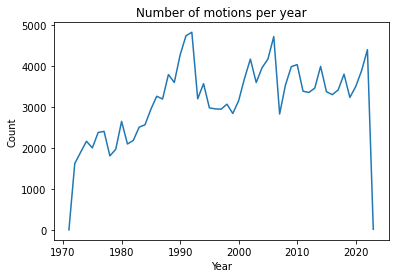

In [19]:
sns.lineplot(data=df.groupby(pd.Grouper(key='date', freq='Y')).size())
plt.title('Number of motions per year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

### Title lengths

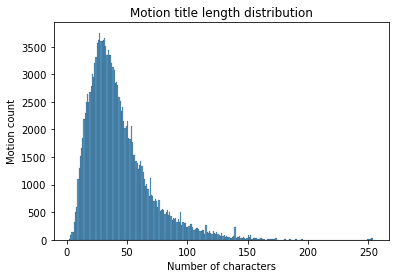

In [20]:
# Plot distribution of title lengths
sns.histplot(df['title'].str.len(), binwidth=1)
plt.title('Motion title length distribution')
plt.xlabel('Number of characters')
plt.ylabel('Motion count')
plt.show()

The distribution as a whole looks reasonable. We've seen that certain titles are the same for multiple documents which may explain the slightly ragged shape.

### Motion text length

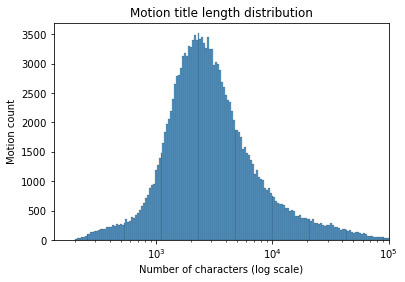

In [21]:
# Plot distribution of text lengths
sns.histplot(df['text'].str.len(), log_scale=True)
plt.title('Motion title length distribution')
plt.xlabel('Number of characters (log scale)')
plt.ylabel('Motion count')
plt.xlim(0, 100_000)
plt.show()

The median lengths is 2 700 and the mean is 5 500. It's quite common for a motion to be 10k characters or longer.